In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt


# 1. Load and Prepare the Data  #
data = pd.read_csv('data/creditcard.csv')
data = data.sort_values('Time')

# Extract features and labels
features = data.drop(columns=['Class', 'Time']).values
labels = data['Class'].values

def train_test_split_sorted(features, labels, test_size=0.2):
    n = len(features)
    n_test = int(n * test_size)
    n_train = n - n_test
    X_train = features[:n_train]
    y_train = labels[:n_train]
    X_test = features[n_train:]
    y_test = labels[n_train:]
    return X_train, X_test, y_train, y_test


"""X_train, X_test, y_train, y_test = train_test_split_sorted(features, labels, test_size=0.25)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Save train and test indices to recreate the dataset
np.savetxt('data/X_train.txt', X_train, fmt='%d')
np.savetxt('data/y_train.txt', y_train, fmt='%d')
np.savetxt('data/X_test.txt', X_test, fmt='%d')
np.savetxt('data/y_test.txt', y_test, fmt='%d')"""

In [70]:
# Load train and test indices
X_train = np.loadtxt('data/X_train.txt')
y_train = np.loadtxt('data/y_train.txt')
X_test = np.loadtxt('data/X_test.txt')
y_test = np.loadtxt('data/y_test.txt')

scaler = StandardScaler().fit(X_train)

In [71]:
# Global variable for the number of features (needed for model input shape)
n_features = X_train.shape[1]

# --------------------------------------#
# 2. Function to Create Sequences       #
# --------------------------------------#
def create_sequences(data, labels, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length + 1):
        X.append(data[i:i+seq_length])
        # Label a sequence as fraudulent if any transaction in it is fraud
        y.append(1 if labels[i:i+seq_length].sum() > 0 else 0)
    return np.array(X), np.array(y)


# 3. Custom HyperModel that Tunes Sequence Length     #
#    and Other Hyperparameters                        #
class LSTMHyperModel(kt.HyperModel):
    def build(self, hp):
        # Tune the sequence length: choose from 5, 10, or 20
        seq_length = hp.Choice('sequence_length', [5, 10, 20])

        model = Sequential()
        # First LSTM layer
        units1 = hp.Int('units_lstm1', min_value=32, max_value=128, step=32)
        model.add(LSTM(units1, input_shape=(seq_length, n_features), return_sequences=True))
        dropout1 = hp.Float('dropout1', min_value=0.1, max_value=0.5, step=0.1)
        model.add(Dropout(dropout1))

        # Second LSTM layer
        units2 = hp.Int('units_lstm2', min_value=16, max_value=64, step=16)
        model.add(LSTM(units2))
        dropout2 = hp.Float('dropout2', min_value=0.1, max_value=0.5, step=0.1)
        model.add(Dropout(dropout2))

        # Dense output layer
        model.add(Dense(1, activation='sigmoid'))

        # Tune learning rate
        learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-1, sampling='LOG')
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
            loss='binary_focal_crossentropy',
            metrics=[
                'accuracy',
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall'),
                tf.keras.metrics.AUC(name='auc')
            ]
        )
        return model

    def fit(self, hp, model, *args, **kwargs):
        seq_length = hp.get('sequence_length')
        X_seq, y_seq = create_sequences(X_train, labels, seq_length)
        X_train_fit, X_val_fit, y_train_train_fit, y_val_fit = train_test_split(
            X_seq, y_seq, test_size=0.2, random_state=42, stratify=y_seq
        )
        
        # Apply SMOTE on the training set
        n_samples, seq_len, n_features_local = X_train_fit.shape
        X_train_flat = X_train_fit.reshape(n_samples, seq_len * n_features_local)
        smote = SMOTE(random_state=42)
        X_train_res, y_train_res = smote.fit_resample(X_train_flat, y_train_train_fit)
        X_train_res = X_train_res.reshape(-1, seq_length, n_features_local)

        return model.fit(
            X_train_res, y_train_res,
            validation_data=(X_val_fit, y_val_fit),
            epochs=10,
            batch_size=64,
            **kwargs
        )

In [72]:
# 4. Set Up and Run the Tuner  #
hypermodel = LSTMHyperModel()

tuner = kt.RandomSearch(
    hypermodel,
    objective=kt.Objective('val_auc', direction='max'),
    max_trials=10,         # Increase for a more thorough search
    executions_per_trial=1,
    directory='hyperparam_tuning',
    project_name='credit_card_fraud_lstm'
)

# Since our HyperModel.fit() method handles data generation,
# we don't need to pass x and y to tuner.search().
tuner.search()

# -----------------------------#
# 5. Evaluate the Best Model   #
# -----------------------------#
# Get the best hyperparameters and model
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_seq_length = best_hp.get('sequence_length')

# For final evaluation, generate a test set using the best sequence length.
X_train_final, y_train_final = create_sequences(X_train, labels, best_seq_length)
X_test_final, y_test_final = create_sequences(X_test, y_test, best_seq_length)

# Apply SMOTE on the training set
n_samples, seq_len, n_features_local = X_train_final.shape
X_train_final_flat = X_train_final.reshape(n_samples, seq_len * n_features_local)
smote = SMOTE(random_state=42)
X_train_final_res, y_train_final_res = smote.fit_resample(X_train_final_flat, y_train_final)
X_train_final_res = X_train_final_res.reshape(-1, best_seq_length, n_features_local)

# Retrieve the best model and evaluate on the test set
best_model = tuner.get_best_models(num_models=1)[0]
loss, accuracy, precision, recall, auc_metric = best_model.evaluate(X_test_final, y_test_final, verbose=0)
print("Best Model Evaluation on Test Set:")
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC: {auc_metric:.4f}")


Trial 10 Complete [00h 12m 47s]
val_auc: 0.9993231892585754

Best val_auc So Far: 0.9999602437019348
Total elapsed time: 02h 06m 35s


c:\Users\Albert Salles\anaconda3\envs\ds\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Best Model Evaluation on Test Set:
Loss: 0.0349
Accuracy: 0.9906
Precision: 0.9322
Recall: 0.6740
AUC: 0.8884


In [73]:
# -----------------------------------------#
# 5. Print All Trials and Best Parameters  #
# -----------------------------------------#

print("\nAll Trial Results:")
for trial in tuner.oracle.trials.values():
    print(f"Trial ID: {trial.trial_id}, Score: {trial.score}, Hyperparameters: {trial.hyperparameters.values}")

best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\nBest Hyperparameters:")
print(best_hp.values)


All Trial Results:
Trial ID: 00, Score: 0.9936185479164124, Hyperparameters: {'sequence_length': 5, 'units_lstm1': 96, 'dropout1': 0.2, 'units_lstm2': 64, 'dropout2': 0.5, 'learning_rate': 0.0009214775215589635}
Trial ID: 01, Score: 0.9944766759872437, Hyperparameters: {'sequence_length': 5, 'units_lstm1': 96, 'dropout1': 0.4, 'units_lstm2': 48, 'dropout2': 0.2, 'learning_rate': 0.009333552981460077}
Trial ID: 02, Score: 0.9999602437019348, Hyperparameters: {'sequence_length': 20, 'units_lstm1': 64, 'dropout1': 0.2, 'units_lstm2': 32, 'dropout2': 0.2, 'learning_rate': 0.00031785936866373}
Trial ID: 03, Score: 0.9983401894569397, Hyperparameters: {'sequence_length': 20, 'units_lstm1': 96, 'dropout1': 0.1, 'units_lstm2': 32, 'dropout2': 0.4, 'learning_rate': 0.012071718310183176}
Trial ID: 04, Score: 0.9988350868225098, Hyperparameters: {'sequence_length': 10, 'units_lstm1': 96, 'dropout1': 0.30000000000000004, 'units_lstm2': 48, 'dropout2': 0.30000000000000004, 'learning_rate': 0.00114

Epoch 1/10
5172/5172 [==============================] - 95s 18ms/step - loss: 0.0188 - accuracy: 0.9761 - precision: 0.9756 - recall: 0.9602 - auc: 0.9965 - val_loss: 0.0093 - val_accuracy: 0.9881 - val_precision: 1.0000 - val_recall: 0.9881 - val_auc: 0.0000e+00
Epoch 2/10
5172/5172 [==============================] - 92s 18ms/step - loss: 0.0036 - accuracy: 0.9957 - precision: 0.9941 - recall: 0.9945 - auc: 0.9999 - val_loss: 8.7703e-04 - val_accuracy: 0.9991 - val_precision: 1.0000 - val_recall: 0.9991 - val_auc: 0.0000e+00
Epoch 3/10
5172/5172 [==============================] - 93s 18ms/step - loss: 0.0019 - accuracy: 0.9978 - precision: 0.9969 - recall: 0.9972 - auc: 1.0000 - val_loss: 0.0013 - val_accuracy: 0.9982 - val_precision: 1.0000 - val_recall: 0.9982 - val_auc: 0.0000e+00
Epoch 4/10
5172/5172 [==============================] - 93s 18ms/step - loss: 0.0014 - accuracy: 0.9983 - precision: 0.9978 - recall: 0.9978 - auc: 1.0000 - val_loss: 4.5124e-04 - val_accuracy: 0.9996 - v

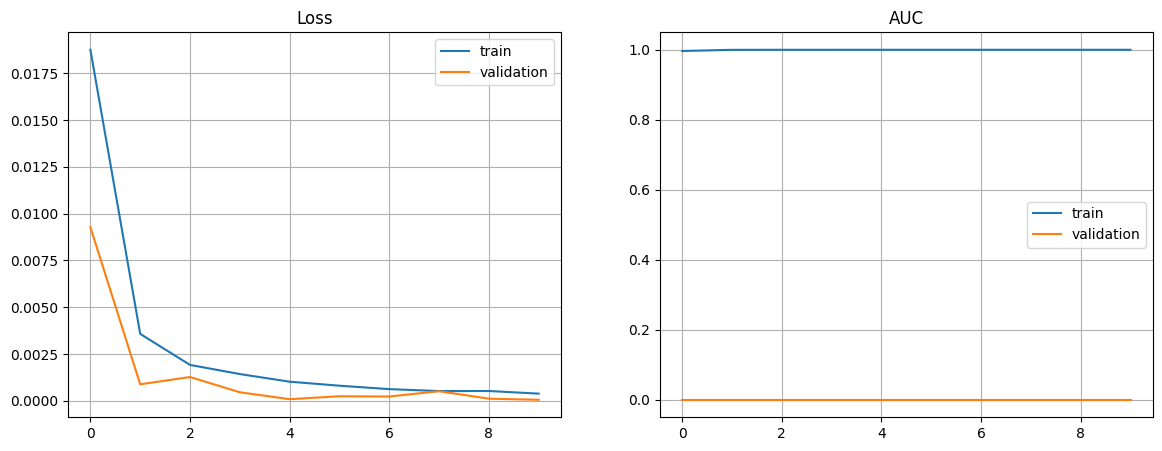

In [74]:
# Train the model with the best hyperparameters using more epochs and plot the learning curve
hypermodel = LSTMHyperModel()
model = hypermodel.build(best_hp)
history = model.fit(
    X_train_final_res, y_train_final_res,
    validation_split=0.2,
    epochs=10,
    batch_size=64
)

# Plot the learning curve
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Loss')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(history.history['auc'], label='train')
plt.plot(history.history['val_auc'], label='validation')
plt.title('AUC')
plt.legend()
plt.grid(True)
plt.tight_layout
plt.show()

2225/2225 [==============================] - 12s 5ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     69406
           1       0.90      0.67      0.77      1776

    accuracy                           0.99     71182
   macro avg       0.95      0.84      0.88     71182
weighted avg       0.99      0.99      0.99     71182

Confusion Matrix:


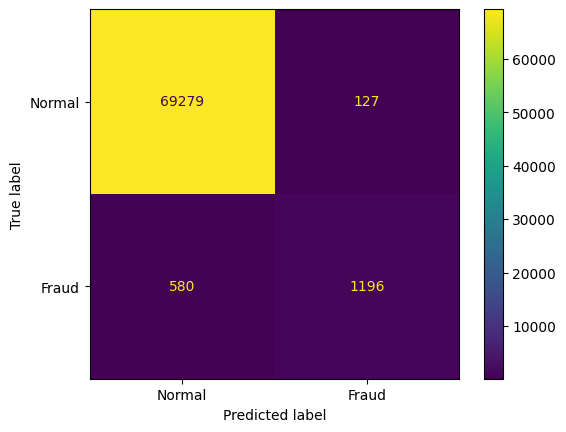

In [75]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Predict the test set
y_pred = model.predict(X_test_final)

# Print a classification report
print("Classification Report:")
print(classification_report(y_test_final, y_pred > 0.5))

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test_final, y_pred > 0.5)
print("Confusion Matrix:")
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Normal', 'Fraud'])
disp.plot()
plt.show()

In [76]:
model.save('model/base_lstm_model.keras')

In [77]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model('model/base_lstm_model.keras')

# Check the model architecture
loaded_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 20, 64)            24064     
                                                                 
 dropout_2 (Dropout)         (None, 20, 64)            0         
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 36513 (142.63 KB)
Trainable params: 36513 (142.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [78]:
def compute_mia_attributes(model, X_train, X_test, y_train, y_test):
    y_train_pred_prob = np.asarray(model.predict(X_train)).reshape(-1, 1)
    y_test_pred_prob = np.asarray(model.predict(X_test)).reshape(-1, 1)

    eps = 1e-6
    y_train_pred_prob_clipped = np.clip(y_train_pred_prob, eps, 1 - eps)
    y_test_pred_prob_clipped = np.clip(y_test_pred_prob, eps, 1 - eps)

    # Compute the logits
    logits_train = np.log(y_train_pred_prob_clipped / (1 - y_train_pred_prob_clipped))
    logits_test = np.log(y_test_pred_prob_clipped / (1 - y_test_pred_prob_clipped))

    # Compute the binary cross-entropy loss
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=False, reduction=tf.keras.losses.Reduction.NONE)
    loss_train = bce(y_train.reshape(-1, 1), y_train_pred_prob_clipped).numpy().reshape(-1)
    loss_test = bce(y_test.reshape(-1, 1), y_test_pred_prob_clipped).numpy().reshape(-1)

    labels_train = y_train.reshape(-1)
    labels_test = y_test.reshape(-1)

    print(f"logits_train shape: {logits_train.shape}")
    print(f"logits_test shape: {logits_test.shape}")
    print(f"loss_train shape: {loss_train.shape}")
    print(f"loss_test shape: {loss_test.shape}")
    print(f"labels_train shape: {labels_train.shape}")
    print(f"labels_test shape: {labels_test.shape}")

    return logits_train, logits_test, loss_train, loss_test, labels_train, labels_test

In [79]:
logits_train, logits_test, loss_train, loss_test, labels_train, labels_test = compute_mia_attributes(
    loaded_model, X_train_final, X_test_final, y_train_final, y_test_final
)

2225/2225 [==============================] - 11s 5ms/step
logits_train shape: (213587, 1)
logits_test shape: (71182, 1)
loss_train shape: (213587,)
loss_test shape: (71182,)
labels_train shape: (213587,)
labels_test shape: (71182,)


In [80]:
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import membership_inference_attack as mia
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackType

# Create an AttackInputData object
attack_input = AttackInputData(
    logits_train=logits_train,
    logits_test=logits_test,
    loss_train=loss_train,
    loss_test=loss_test,
    labels_train=labels_train,
    labels_test=labels_test
)

slicing_spec = SlicingSpec(
    entire_dataset=True,
    by_class=True,
    by_percentiles=True,
    by_classification_correctness=True
)

attacks_result = mia.run_attacks(
    attack_input,
    slicing_spec,
    attack_types=[AttackType.THRESHOLD_ATTACK, AttackType.LOGISTIC_REGRESSION]
)

c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

In [81]:
print(attacks_result.summary(by_slices=True))

Best-performing attacks over all slices
  LOGISTIC_REGRESSION (with 6742 training and 1776 test examples) achieved an AUC of 0.74 on slice CLASS=1
  LOGISTIC_REGRESSION (with 6742 training and 1776 test examples) achieved an advantage of 0.44 on slice CORRECTLY_CLASSIFIED=False
  LOGISTIC_REGRESSION (with 20015 training and 8468 test examples) achieved a positive predictive value of 1.00 on slice Loss percentiles: 30-40
  LOGISTIC_REGRESSION (with 23892 training and 4585 test examples) achieved top-5 epsilon lower bounds of 6.8205, 6.8185, 6.8164, 6.8144, 6.8123 on slice Loss percentiles: 90-100

Best-performing attacks over slice: "Entire dataset"
  LOGISTIC_REGRESSION (with 213587 training and 71182 test examples) achieved an AUC of 0.62
  LOGISTIC_REGRESSION (with 213587 training and 71182 test examples) achieved an advantage of 0.19
  LOGISTIC_REGRESSION (with 213587 training and 71182 test examples) achieved a positive predictive value of 0.86
  THRESHOLD_ATTACK (with 213587 train

In [82]:
max_auc_attacker = attacks_result.get_result_with_max_auc()
max_advantage_attacker = attacks_result.get_result_with_max_attacker_advantage()
max_epsilon_attacker = attacks_result.get_result_with_max_epsilon()

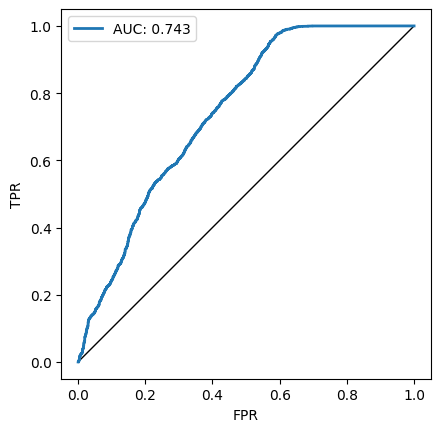

In [83]:
import tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.plotting as plotting

figure = plotting.plot_roc_curve(max_auc_attacker.roc_curve)

In [ ]:
import pandas as pd

pd.set_option("display.max_rows", 8, "display.max_columns", None)
print(attacks_result.calculate_pd_dataframe())

           slice feature slice value  train size  test size  \
0         Entire dataset                  213587      71182   
1         Entire dataset                  213587      71182   
2                  class           0      206845      69406   
3                  class           0      206845      69406   
..                   ...         ...         ...        ...   
26  correctly_classified        True      206845      69406   
27  correctly_classified        True      206845      69406   
28  correctly_classified       False        6742       1776   
29  correctly_classified       False        6742       1776   

            attack type  Attacker advantage  Positive predictive value  \
0      THRESHOLD_ATTACK            0.171349                   0.817271   
1   LOGISTIC_REGRESSION            0.188433                   0.861897   
2      THRESHOLD_ATTACK            0.181146                   0.749251   
3   LOGISTIC_REGRESSION            0.182129                   0.902439   